In [172]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
from geopy.geocoders import Nominatim
from pandas_ods_reader import read_ods
import math

#Set parameters to geolocate
geolocator = Nominatim(user_agent="useer_agent", domain='nominatim.openstreetmap.org')
geocode = partial(geolocator.geocode, language="it", country_codes = "ita")

#Reachable cities
dft = pd.read_csv("../Dati/distanze/times_computed.csv", delimiter=";", encoding = "ISO-8859-1", index_col=0)
cities = dft.columns
dfc=pd.read_csv("../Dati/altro/CitiesLocation.csv", delimiter=';')

lat = dfc["Lat"]
lon = dfc["Lon"]
cities = dfc["City"]

lonmin = round(lon.min()*100)/100
lonmax = math.ceil(lon.max()*10)/10
latmin = (round(lat.min() * 10)-1)/10
latmax = math.ceil(lat.max()*100)/100

In [183]:
def getLocation(name):
    geolocator = Nominatim(user_agent="useer_agent")
    geocode = partial(geolocator.geocode, language="it")
    location =geolocator.geocode(name)
    return location.latitude, location.longitude

def getCoords(string, z):
    return pd.Series(z).str.contains(string, case=False).values

def crop(cities_list):
    
    y_positions = [dfc.Lat[getCoords(paese, dfc.City)].values[0] for paese in cities_list.dropna()]
    x_positions = [dfc.Lon[getCoords(paese, dfc.City)].values[0] for paese in cities_list.dropna()]
    
    ruh_m = plt.imread('../Dati/altro/map.JPG')
    map_sizey, map_sizex, _ = ruh_m.shape
    nlonmin = round(min(x_positions)*100)/100
    nlonmax = math.ceil(max(x_positions)*10)/10
    nlatmin = (round(min(y_positions) * 10)-1)/10
    nlatmax = math.ceil(max(y_positions)*100)/100
    xmin = int(round((map_sizex*(nlonmin-lonmin))/(lonmax-lonmin)))
    xmax = int(round((map_sizex*(nlonmax-lonmin))/(lonmax-lonmin)))
    ymin = int(round(map_sizey*((nlatmin-latmin) / (latmax-latmin))))
    ymax = int(round(map_sizey*((nlatmax-latmin) / (latmax-latmin))))
    return ruh_m[map_sizey-ymax:map_sizey-ymin, xmin:xmax], nlonmin, nlonmax, nlatmin, nlatmax, x_positions, y_positions

def get_row(df, string):
    return pd.Series(df.index).str.contains(string, case=False)

def getName(nome):
    city = dft[get_row(dft, nome).values].index[0]
    return city.split(",")[0].strip()

In [184]:
(min(lat), max(lat), min(lon), max(lon))

(44.9286315, 45.470343299999996, 9.493822300000001, 10.520690400000001)

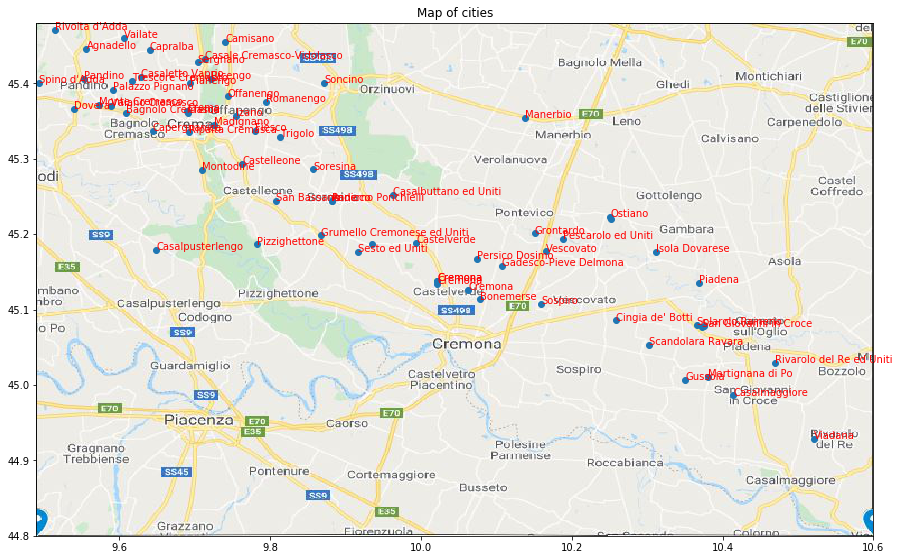

In [200]:
BBox = (lonmin, lonmax,
        latmin, latmax)
ruh_m = plt.imread('../Dati/altro/map.jpg')

fig, ax = plt.subplots(figsize = (15,10))
ax.scatter(df.Lon, df.Lat, zorder=1, alpha=1, marker="o")
ax.set_title('Map of cities')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
k=0
for i, txt in enumerate(cities.unique()[:len(cities)-1]):
    try:
        k+=1
        txt.index(",")
        ax.annotate(txt[:txt.index(',')], (coords[i][1], coords[i][0]), zorder=2, color="red")
    except:
        k+=1
        
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')


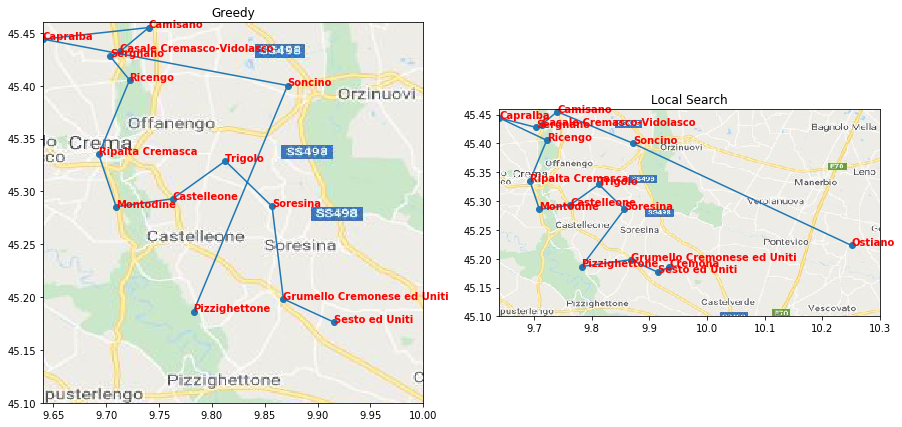

In [199]:
day="lunedi"
f1 = pd.read_csv("../Dati/turni_f/furgoncino1_routing.csv", sep=";")


ruh_m, nlonmin, nlonmax, nlatmin, nlatmax, x_positions, y_positions = crop(f1[day])

BBox = (nlonmin, nlonmax,
        nlatmin, nlatmax)
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(1, 2, 1)
#fig, ax = plt.subplots(figsize = (10,10))

ax.plot(x_positions, y_positions, zorder=1, alpha=1, marker="o")
ax.set_title('Greedy')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
for i, txt in enumerate(f1[day][:len(f1[day].dropna())]):
    try:
        ax.annotate(getName(txt), (x_positions[i], y_positions[i]), zorder=2, aplha=0.5, color='red', fontweight="bold")
    except:
        ax.annotate(getName(txt), (x_positions[i], y_positions[i]), zorder=2, color='red', fontweight="bold")
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')

f1 = pd.read_csv("../Dati/turni_f/ls1_shifts.csv", sep=";")


ruh_m, nlonmin, nlonmax, nlatmin, nlatmax, x_positions, y_positions = crop(f1[day])

BBox = (nlonmin, nlonmax,
        nlatmin, nlatmax)
ax = f.add_subplot(1, 2, 2)
#fig, ax = plt.subplots(figsize = (10,10))

ax.plot(x_positions, y_positions, zorder=1, alpha=1, marker="o")
ax.set_title('Local Search')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
for i, txt in enumerate(f1[day][:len(f1[day].dropna())]):
    try:
        ax.annotate(getName(txt), (x_positions[i], y_positions[i]), zorder=2, aplha=0.5, color='red', fontweight="bold")
    except:
        ax.annotate(getName(txt), (x_positions[i], y_positions[i]), zorder=2, color='red', fontweight="bold")
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')
plt.show()
